In [13]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_COLOR_DESAT = '#D98C90'
CR_COLOR_DESAT = '#A0A0A0'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#,'#6ded94','#50d979','#36bf5f']

# did_not_learn_animals = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
animals = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174','BS_111','BS_92']
# did not learn
#92, unilateral, also cloudy - CR example from here
#103, bilateral, but cloudy
#111, unilateral, clear - NCR example from here
#179, only recorded for two days???


#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'P:\\Behavioor'

In [2]:
class TrialInterval:
    _startTimeSamples = 0
    _endTimeSamples = 0
    _isStartTimeRelToResponse = True
    _isEndTimeRelToResponse = True
    _averageLickDelay = 0.2 * 30000

    def __init__(self,start,end,startresp,endresp):
        self._startTimeSamples = start
        self._endTimeSamples = end
        self._isStartTimeRelToResponse = startresp
        self._isEndTimeRelToResponse = endresp

    def _CalculateAvgLickDelay(self,sessionfile):
        go_responses = np.array(sessionfile.trials.response)[sessionfile.trials.go]
        go_starts = np.array(sessionfile.trials.starts)[sessionfile.trials.go]
        self._averageLickDelay = np.nanmean(go_responses - go_starts)

    def _ToTimestamp(self,sessionfile,trial):
        starttime = sessionfile.trials.starts[trial]
        if self._isStartTimeRelToResponse:
            starttime = sessionfile.trials.response[trial]
            if np.isnan(starttime):
                starttime = sessionfile.trials.starts[trial] + self._averageLickDelay
        starttime = starttime + self._startTimeSamples

        endtime = sessionfile.trials.starts[trial]
        if self._isEndTimeRelToResponse:
            endtime = sessionfile.trials.response[trial]
            if np.isnan(endtime):
                endtime = sessionfile.trials.starts[trial] + self._averageLickDelay
        endtime = endtime + self._endTimeSamples

        return [starttime,endtime]

    def _ToString(self):
        return f"Interval has start {self._startTimeSamples}, end {self._startTimeSamples}. startresp {self._isStartTimeRelToResponse} and endresp {self._isEndTimeRelToResponse}"

# def statisticalComparison(sessionfile,clust,preCondition,postCondition):
#     preInterval = TrialInterval(0,2.5*sessionfile.meta.fs,False,False)
#     postInterval = TrialInterval(0,2.5*sessionfile.meta.fs,False,False)
    
#     allConditions = ilep.getAllConditions(sessionfile,clust)
#     preTrials = allConditions[preCondition].trials
#     postTrials = allConditions[postCondition].trials
        
#     preTrialRates = np.full_like(preTrials,np.nan,dtype='float')
#     postTrialRates = np.full_like(postTrials,np.nan,dtype='float')    
#     for idx,trial in enumerate(preTrials):
#         start,end = preInterval._ToTimestamp(sessionfile,trial)
#         spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=start,endtime=end)
#         preTrialRates[idx] = len(spikes) / ((end-start)/sessionfile.meta.fs)
#     for idx,trial in enumerate(postTrials):
#         start,end = postInterval._ToTimestamp(sessionfile,trial)
#         spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=start,endtime=end)
#         postTrialRates[idx] = len(spikes) / ((end-start)/sessionfile.meta.fs)
        
#     pvalue_inc = mannwhitneyu(preTrialRates,postTrialRates,alternative='less').pvalue
#     pvalue_dec = mannwhitneyu(preTrialRates,postTrialRates,alternative='greater').pvalue
#     if pvalue_inc <= 0.05:# and np.median(postTrialRates) > np.median(preTrialRates):
#         label = 'increased'
#         pvalue = pvalue_inc
#     elif pvalue_dec <= 0.05:# and np.median(postTrialRates) < np.median(preTrialRates):
#         label = 'decreased'
#         pvalue = pvalue_dec
#     else:
#         label = 'unchanged'
#         pvalue = np.min(pvalue_inc,pvalue_dec)
#     return label,pvalue

def statisticalComparison(sessionfile,clust,preCondition,postCondition,preInterval,postInterval,iterations=5000,sample_percent=0.5,pthresh=0.95,modthresh=0.1):
    if pthresh < 0.5:
        raise Exception('pthresh cannot be less than 50%!')
    
    preInterval = TrialInterval(0,2.5*sessionfile.meta.fs,False,False)
    postInterval = TrialInterval(0,2.5*sessionfile.meta.fs,False,False)
    
    allConditions = ilep.getAllConditions(sessionfile,clust)
    preTrials = allConditions[preCondition].trials
    postTrials = allConditions[postCondition].trials
    
    if preCondition == postCondition:
        paired=True
    else:
        paired=False
    
    preTrialRates = np.full_like(preTrials,np.nan,dtype='float')
    postTrialRates = np.full_like(postTrials,np.nan,dtype='float')
    
    for idx,trial in enumerate(preTrials):
        start,end = preInterval._ToTimestamp(sessionfile,trial)
        spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=start,endtime=end)
        preTrialRates[idx] = len(spikes) / ((end-start)/sessionfile.meta.fs)
        
    for idx,trial in enumerate(postTrials):
        start,end = postInterval._ToTimestamp(sessionfile,trial)
        spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=start,endtime=end)
        postTrialRates[idx] = len(spikes) / ((end-start)/sessionfile.meta.fs)
    
    increased=0
    decreased=0
    unchanged=0
    
    for i in range(iterations):
        if paired and len(preTrialRates) != len(preTrialRates):
            raise Exception('Non-equal length paired comparison')
        if paired:
            raise Exception('Paired comparison is not yet implemented')
        else:
            preIdxs = range(len(preTrialRates))
            postIdxs = range(len(postTrialRates))
            preIdxs = np.random.permutation(preIdxs)
            postIdxs = np.random.permutation(postIdxs)
            maxIdx = int(sample_percent*min(len(preIdxs),len(postIdxs)))
            preIdxs = preIdxs[range(maxIdx)]
            postIdxs = postIdxs[range(maxIdx)]
            
        preTrialsToCompare = preTrialRates[preIdxs]
        postTrialsToCompare = postTrialRates[postIdxs]
        
        deltaTrialMean = np.mean(postTrialsToCompare - preTrialsToCompare)
        
        if deltaTrialMean >= modthresh:
            increased+=1
        elif deltaTrialMean <= -modthresh:
            decreased+=1
        else:
            unchanged+=1
            
    p_increased = increased / (increased+decreased+unchanged)
    p_decreased = decreased / (increased+decreased+unchanged)
    p_unchanged = unchanged / (increased+decreased+unchanged)
    
    print(f"inc: {p_increased}, dec: {p_decreased}, unch: {p_unchanged}")
    
    if p_increased >= pthresh:
        label='increased'
        pval = 1-p_increased
    elif p_decreased >= pthresh:
        label='decreased'
        pval = 1-p_decreased
    elif p_unchanged >= pthresh:
        label='unchanged'
        pval = 1-p_unchanged
    else:
        label='inconclusive'
        pval=1-np.max([p_increased,p_decreased,p_unchanged])
    return label,pval

In [3]:
#this function calculates pval for one cluster(one cell)
def calculate_NCR_CR_pval(sessionfile,clust):

    #convert window(100ms) in samples
    sessionfile.meta.fs #30000 samples / second from blackrock
    window = sessionfile.meta.fs * 0.1
    trials_to_use = sessionfile.trim[clust].trimmed_trials

    #create array for stimulus period
    #tone play start time
    onset_window_start_time = np.zeros(len(trials_to_use))
    for idx, trial in enumerate(trials_to_use):
        onset_window_start_time[idx] = sessionfile.trials.starts[trial]

    #tone play end time
    onset_window_end_time = onset_window_start_time + window
    #offset window start time
    offset_window_start_time = onset_window_end_time
    #offset window end time
    offset_window_end_time = offset_window_start_time + window
    #stimulus array
    stimulus_array = np.zeros([len(onset_window_start_time),2,2])
    for i in range(len(onset_window_start_time)):
        stimulus_array[i] = [[onset_window_start_time[i],onset_window_end_time[i]],
                             [offset_window_start_time[i],offset_window_end_time[i]]
                            ]

    #create array for baseline period
    base_window1_start = onset_window_start_time - 3*window
    base_window1_end = onset_window_start_time - 2*window
    base_window2_start = base_window1_end
    base_window2_end = onset_window_start_time - 1*window
    base_window3_start = base_window2_end
    base_window3_end = onset_window_start_time

    baseline_array = np.zeros([len(base_window1_start),3,2])
    for i in range(len(onset_window_start_time)):
        baseline_array[i] = [[base_window1_start[i],base_window1_end[i]],
                             [base_window2_start[i],base_window2_end[i]],
                             [base_window3_start[i],base_window3_end[i]],
                            ]

    #evaluate spike count within stimulus window
    spikecounts_stimuluswindow = np.zeros((len(onset_window_start_time),2))

    for idx, t in enumerate(stimulus_array):
        #print(t[0][0])

        #spike count from onset window
        spikecount_onsetwindow = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[0][0],endtime=t[0][1]))

        #spike count from offset window
        spikecount_offsetwindow = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[1][0],endtime=t[1][1]))

        spikecounts_stimuluswindow[idx][0]=spikecount_onsetwindow
        spikecounts_stimuluswindow[idx][1]=spikecount_offsetwindow

    #evaluate spike count within baseline window
    spikecounts_basewindow = np.zeros((len(onset_window_start_time),3))

    for idx, t in enumerate(baseline_array):
        #print(t[0][0])

        #spike count from window1
        spikecount_base_window1 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[0][0],endtime=t[0][1]))

        #spike count from window2
        spikecount_base_window2 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[1][0],endtime=t[1][1]))

        #spike count from window3
        spikecount_base_window3 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[2][0],endtime=t[2][1]))

        spikecounts_basewindow[idx][0]=spikecount_base_window1
        spikecounts_basewindow[idx][1]=spikecount_base_window2
        spikecounts_basewindow[idx][2]=spikecount_base_window3

    ###### CODE BELOW HERE SHOULD LOOP 5000 TIMES 
    iterations = 5000
    #spikecounts_diff_mean_arr = []

    CR_evok_appear=0
    CR_sup_appear=0
    NCR_appear=0

    for i in range(iterations):

        #1.subsampled 90% of the spike count changes from baseline,
        #2.calculated the mean of these values, repeated this process 5000 times 

        #1.
        #subsampled 90% trials
        trials = range(len(spikecounts_stimuluswindow))
        trials_perm = np.random.permutation(trials)
        trials_subsamp = trials_perm[range(int(0.9*len(trials_perm)))]

        #calculate spike count changes from baseline in the subsample
        spikecounts_diff = []
        for trial_idx in trials_subsamp:
            random_stimulus = spikecounts_stimuluswindow[trial_idx][np.random.randint(2)]
            random_base = spikecounts_basewindow[trial_idx][np.random.randint(3)]
            spikecounts_diff.append(random_stimulus-random_base)

        #2. 
        #calculate the mean of the spike counts diff  
        spikecounts_diff_mean = np.mean(spikecounts_diff)
        #calculate the # of appearance in each categotiry in 5000 iterations
        if spikecounts_diff_mean > 0.1:
            CR_evok_appear+=1
        elif spikecounts_diff_mean < -0.1:
            CR_sup_appear+=1
        else:
            NCR_appear+=1
            
    p_value_evoked = CR_evok_appear/(iterations)
    p_value_suppressed = CR_sup_appear/(iterations)
    p_value_NCR = NCR_appear/(iterations)
    return p_value_evoked, p_value_suppressed, p_value_NCR

In [4]:
def get_response_times_with_default(sessionfile):
    response_times_in_trial = (sessionfile.trials.response-sessionfile.trials.starts)
    default_response_time = np.nanmedian(response_times_in_trial)

    response_times = sessionfile.trials.response
    nogo_trials = np.isnan(response_times)
    response_times[nogo_trials] = sessionfile.trials.starts[nogo_trials]+default_response_time
    return response_times

In [5]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Fetching files for DS_16
Fetching files for DS_17
Fetching files for DS_19
Fetching files for DS_22
Fetching files for DS_23
Fetching files for DS_24
Fetching files for DS_27
Fetching files for DS_28
Fetching files for DS_13
Fetching files for BS_173
Fetching files for BS_175
Fetching files for BS_187
Fetching files for BS_188
Fetching files for BS_213
Fetching files for BS_214
Fetching files for TH_217
Fetching files for AE_235
Fetching files for AE_236
Fetching files for TH_237
Fetching files for AE_252
Fetching files for AE_254
Fetching files for AE_238
Fetching files for AE_239
Fetching files for AE_240
Fetching files for AE_267
Fetching files for AO_273
Fetching files for AO_274
Fetching files for AE_287
Fetching files for AE_301
Fetching files for AE_312
P:\Behavioor\BS_61\behavior\BS_61_42v2_reversal.txt: No columns to parse from file
P:\Behavioor\BS_103\behavior\BS_103_11v4_opto.txt: No columns to parse from file
Error loading P:\Behavioor\BS_123\behavior\BS_123_18v1_opto.txt: 

../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


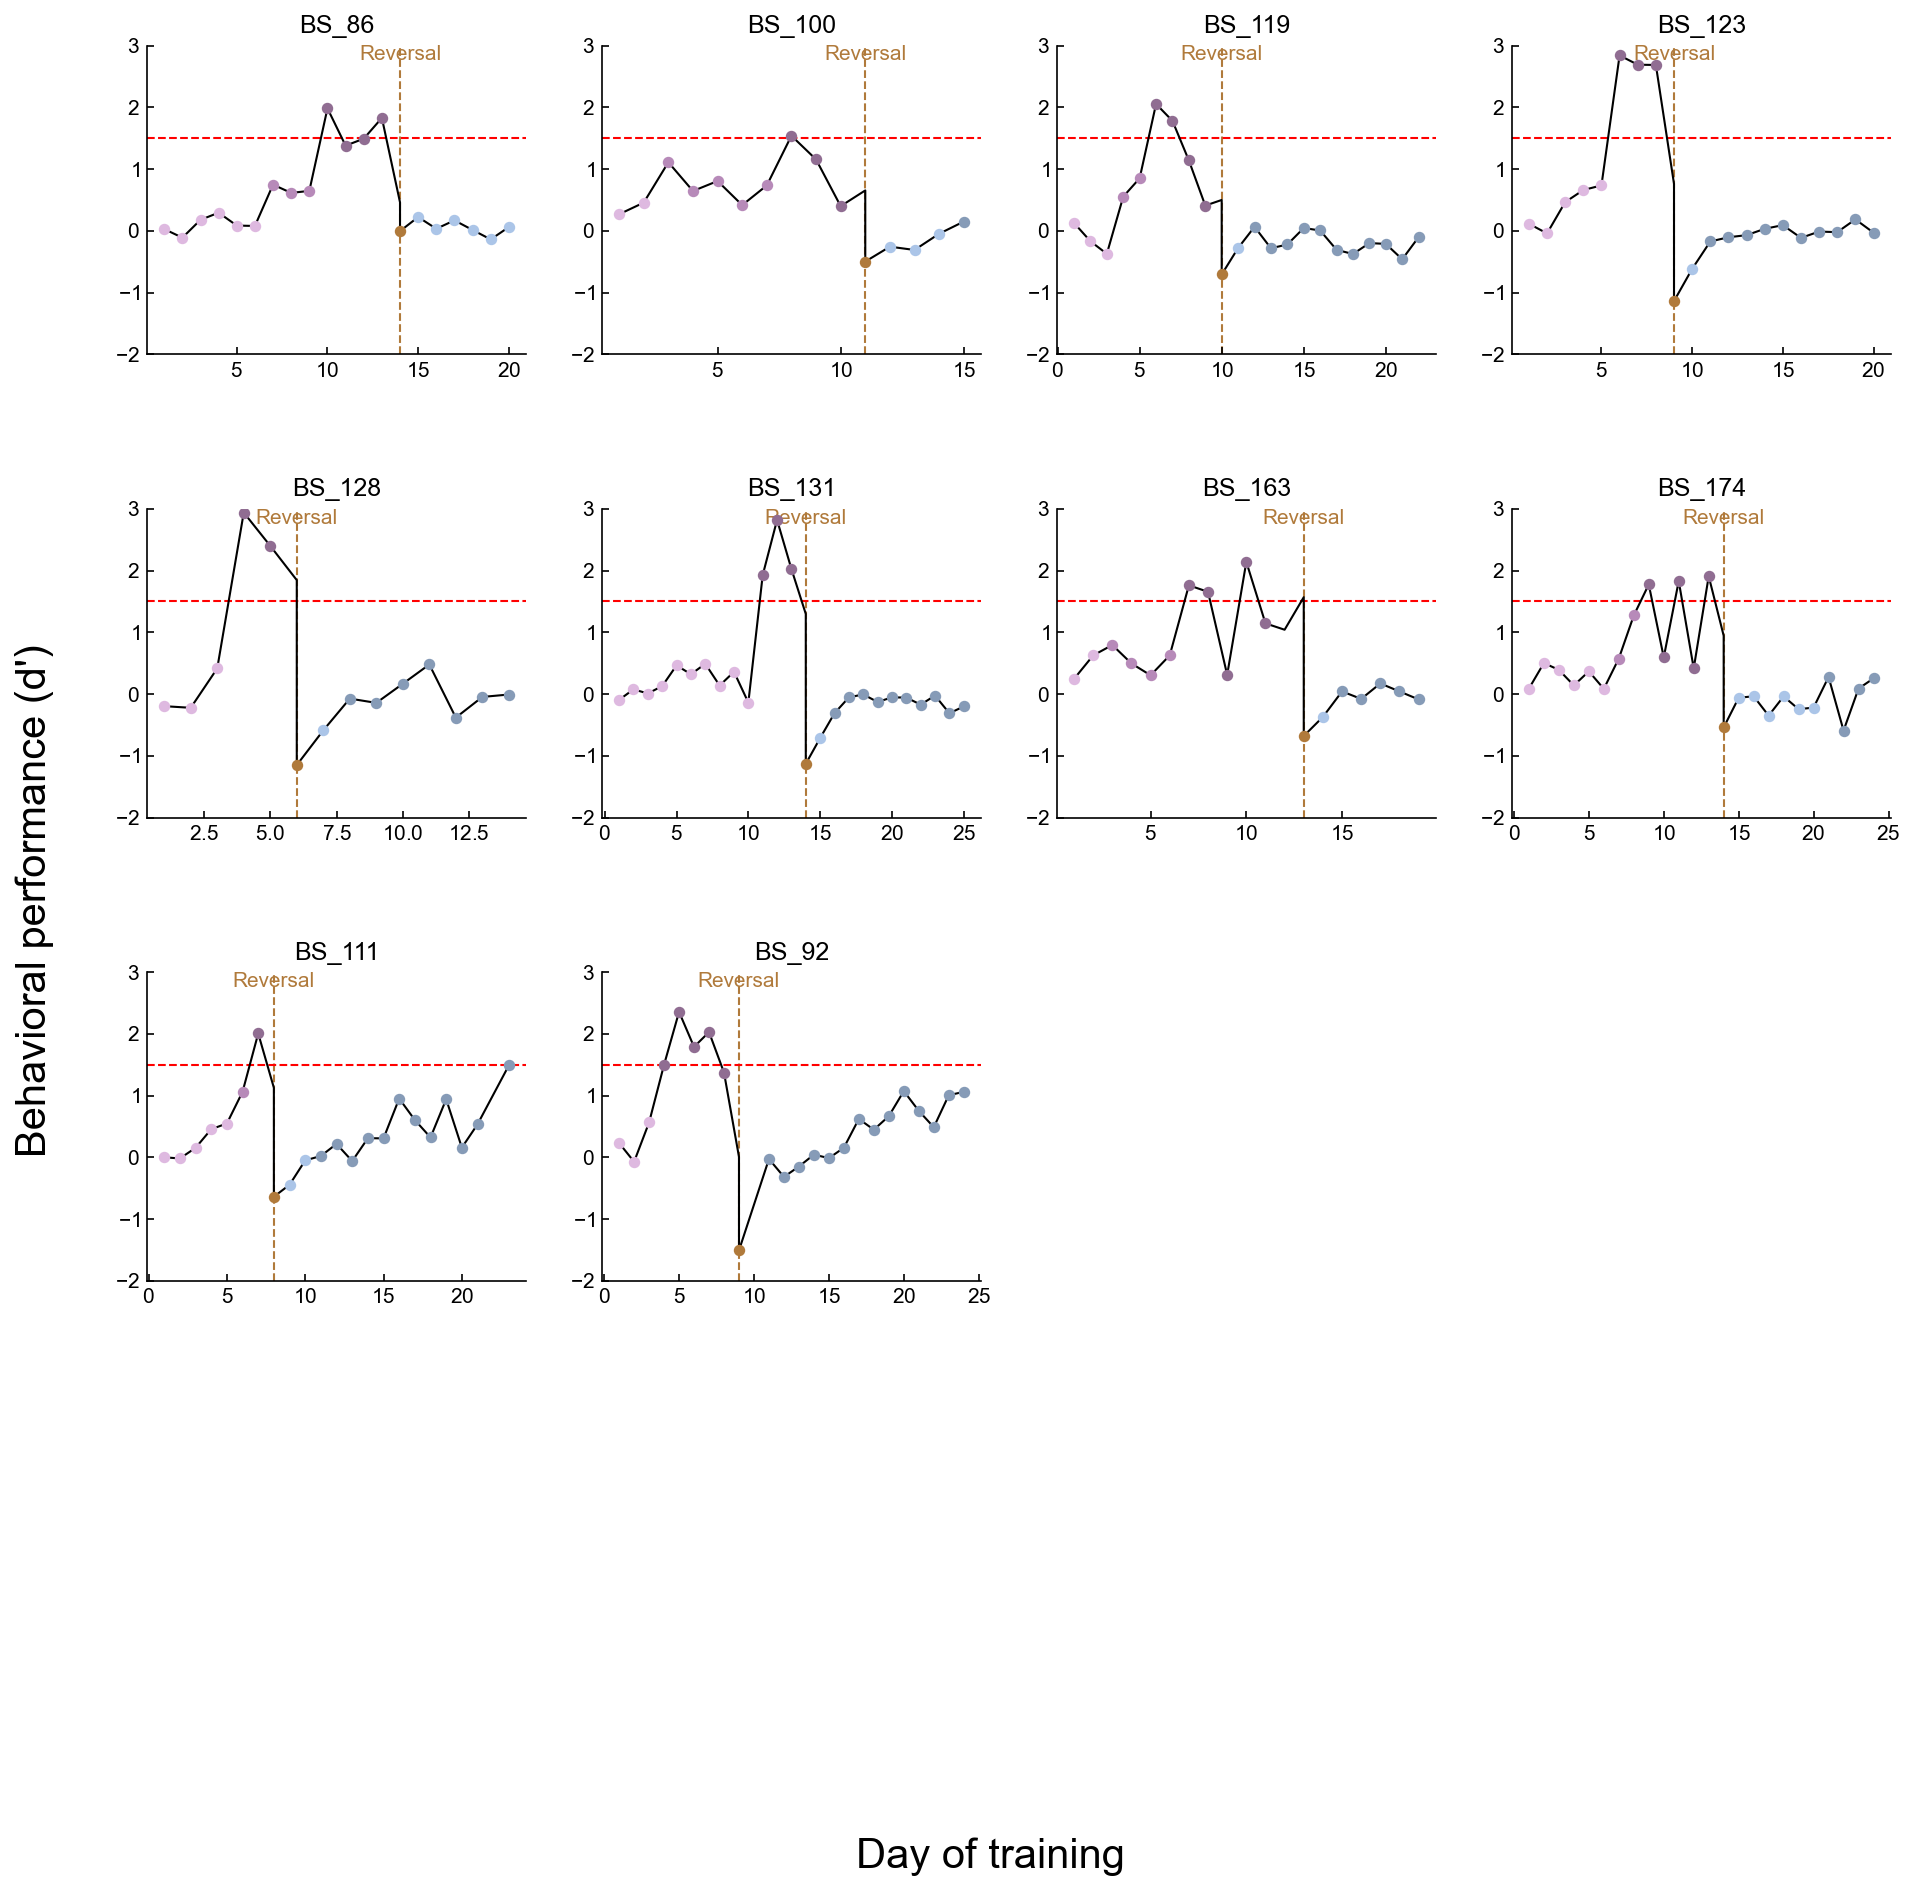

In [14]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True,noTrimPost=True)

In [15]:
EnumSession = []
EnumClust = []
sessions = os.listdir(ops_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    
    if sessionfile.meta.task == 'passive no behavior':
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
    
    if sessionfile.meta.animal not in animals:
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 167/167 [00:03<00:00, 54.17it/s]


In [16]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
        raise e
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1339/1339 [00:36<00:00, 36.53it/s]

errors for: []


# Folder Reset

In [144]:
### Reset raster directory
os.mkdir(os.path.join('D:\\\\Rasters','OpsinStimRasters'))
os.mkdir(os.path.join('D:\\\\Rasters','OpsinStimRasters','pngs'))
os.mkdir(os.path.join('D:\\\\Rasters','OpsinStimRasters','pdfs'))
for modcat in ['CR','NCR','Middle']:
    os.mkdir(os.path.join('D:\\\\Rasters','OpsinStimRasters',modcat))
    os.mkdir(os.path.join('D:\\\\Rasters','OpsinStimRasters',modcat,'pdfs'))
    os.mkdir(os.path.join('D:\\\\Rasters','OpsinStimRasters',modcat,'pngs'))
    for phase in ['pre early','pre late','pre expert','switch','post early','post late','post expert']:
        os.mkdir(os.path.join('D:\\\\Rasters','OpsinStimRasters',modcat,phase))
        os.mkdir(os.path.join('D:\\\\Rasters','OpsinStimRasters',modcat,phase,'pdfs'))
        os.mkdir(os.path.join('D:\\\\Rasters','OpsinStimRasters',modcat,phase,'pngs'))

In [177]:
### Reset raster directory
os.mkdir(os.path.join('D:\\\\Rasters','OpsinStimRastersUnmodulated'))
os.mkdir(os.path.join('D:\\\\Rasters','OpsinStimRastersUnmodulated','pngs'))
os.mkdir(os.path.join('D:\\\\Rasters','OpsinStimRastersUnmodulated','pdfs'))
for modcat in ['CR','NCR','Middle']:
    os.mkdir(os.path.join('D:\\\\Rasters','OpsinStimRastersUnmodulated',modcat))
    os.mkdir(os.path.join('D:\\\\Rasters','OpsinStimRastersUnmodulated',modcat,'pdfs'))
    os.mkdir(os.path.join('D:\\\\Rasters','OpsinStimRastersUnmodulated',modcat,'pngs'))
    for phase in ['pre early','pre late','pre expert','switch','post early','post late','post expert']:
        os.mkdir(os.path.join('D:\\\\Rasters','OpsinStimRastersUnmodulated',modcat,phase))
        os.mkdir(os.path.join('D:\\\\Rasters','OpsinStimRastersUnmodulated',modcat,phase,'pdfs'))
        os.mkdir(os.path.join('D:\\\\Rasters','OpsinStimRastersUnmodulated',modcat,phase,'pngs'))

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'D:\\\\Rasters\\OpsinStimRastersUnmodulated'

# Plotting Code

In [46]:
def visualizeClusterChoiceInternal(sessionfile,clust,ax1,ax2,Figure_start_time_ms=-250,Figure_end_time_ms=1000,xtickstouse=[0,500,1000],align_to_choice=False,switch_cond='NA',limitToUse=None):
    buffer = 250
    sort_by_response_latency = False # Not implemented
    bw_scott_factor = 3
    
    if align_to_choice:
        mn = 1.9
        spread = 1
    else:
        mn = 3.5
        spread = 2
    
    condition_of_interest = 'ERROR'
    assert (sessionfile.meta.task not in ['switch','opto switch','tuning_switch','second switch']) or (switch_cond != 'NA')
    if align_to_choice:
        if sessionfile.meta.task in ['switch','opto switch','tuning_switch','second switch']:
            condition_of_interest = switch_cond+'_go'
        else:
            condition_of_interest = 'go'
    else:
        if sessionfile.meta.task in ['switch','opto switch','tuning_switch','second switch']:
            condition_of_interest = switch_cond
        else:
            condition_of_interest = 'all_trials'
    
    response_times = sessionfile.trials.response#get_response_times_with_default(sessionfile)
#     ax1.spines['bottom'].set_visible(False)
#     ax1.spines['left'].set_visible(False)
#     ax1.get_xaxis().set_visible(False)
#     ax1.get_yaxis().set_visible(False)

    if align_to_choice:
        Y = sessionfile.responsiveness[clust][condition_of_interest].FRmodulation_choice
    else:
        Y = sessionfile.responsiveness[clust][condition_of_interest].FRmodulation
    if np.isnan(Y):
        color_to_use = 'k'
    else:
        color_to_use = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )

    ### Get set of all trials to consider
    allConditions = ilep.getAllConditions(sessionfile,clust,trialsPerDayLoaded='NO_TRIM')
    trialsToPlot = allConditions[condition_of_interest].trials
    
    ### Reorder trials
    # Nogo then go
#     trialsToPlot = np.concatenate((allConditions['nogo'].trials,allConditions['go'].trials))
#     # Just nogo
#     trialsToPlot = allConditions['nogo'].trials
    trialsToPlot = np.concatenate((allConditions['laser_on'].trials,allConditions['laser_off'].trials))
    num_on = len(allConditions['laser_on'].trials)
    num_off = len(allConditions['laser_off'].trials)
    ### End trial reordering

    ### Extract spike times
    clustSpikes = ilep.getSpikeTimes(sessionfile,clust=clust)
    trialSpikes = []
    trialStimTimes = []
    trialChoiceTimes = []
    for trial in trialsToPlot:

        #Need to get spike times for each trail...
        if align_to_choice:
            starttime = response_times[trial]+(Figure_start_time_ms-buffer)*sessionfile.meta.fs/1000
            endtime = response_times[trial]+(Figure_end_time_ms+buffer)*sessionfile.meta.fs/1000
        else:
            starttime = sessionfile.trials.starts[trial]+(Figure_start_time_ms-buffer)*sessionfile.meta.fs/1000
            endtime = sessionfile.trials.starts[trial]+(Figure_end_time_ms+buffer)*sessionfile.meta.fs/1000
        
        this_trial_spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=starttime,endtime=endtime)
        if align_to_choice:
            this_trial_spikes = this_trial_spikes - response_times[trial]
        else:
            this_trial_spikes = this_trial_spikes - sessionfile.trials.starts[trial]
        this_trial_spikes = this_trial_spikes * 1000 / sessionfile.meta.fs

        trialSpikes.append(this_trial_spikes)
        if align_to_choice:
            trialStimTimes.append(-(response_times[trial]-sessionfile.trials.starts[trial])/sessionfile.meta.fs*1000)
            trialChoiceTimes.append(0)
        else:
            trialStimTimes.append(0)
            trialChoiceTimes.append((response_times[trial]-sessionfile.trials.starts[trial])/sessionfile.meta.fs*1000)
    trialSpikes = np.array(trialSpikes,dtype='object')

    #Plot Raster
    for idx,trial in enumerate(trialsToPlot):
        if idx < num_on:
            color_to_use = LASER_COLOR
        else:
            color_to_use = 'k'
        ax1.scatter(trialSpikes[idx],np.ones_like(trialSpikes[idx])*idx,color=color_to_use,s=5,marker='o',lw=0,zorder=0)
            
    ### Plot stimulus times
    if align_to_choice:
        ax1.scatter(trialStimTimes,range(len(trialsToPlot)),marker='o',fc='k',ec='k',zorder=1,s=5,lw=0)
    ### Plot response times
    if align_to_choice:
        ax1.scatter(trialChoiceTimes,range(len(trialsToPlot)),marker='o',fc='g',ec='g',zorder=1,s=10,lw=0)

#     if EIL == 'switch':
#        try:
#            switch_point = np.where(np.greater(trialsToPlot,200))[0][0]-0.5
#            ax1.axhline(switch_point,linestyle='--',lw=1,zorder=-10,color='k')
#        except:
#            pass
    
    #Legend
#     ax1.scatter([],[],marker='o',fc='k',ec='k',s=15,label='stimulus')
#     ax1.scatter([],[],marker='o',fc='g',ec='g',s=15,label='response')
#     lgd = ax1.legend(frameon=False,loc=(-0.25,1),ncol=2,fontsize=14)
    
    #Set trial limits
#     max_trial_value = len(trialsToPlot)
#     sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])#,220,240,260,280,300,320,340,360,380,400])
#     idx_of_okay_limits = np.less_equal(sequence_of_possible_axis_limits,max_trial_value)
#     valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
#     if not len(valid_limits) > 0:
#         return False,[]
#     limit = np.max(valid_limits)
#     ax1.set_xlim([starttime,endtime])
#     ax1.set_ylim([0,limit])
#     ax1.set_yticks([0,limit/2,limit])
#     ax1.set_ylabel('Trial')
    ax1.set_yticks([num_on/2,num_on+num_off/2])
    ax1.set_yticklabels(['ON','OFF'])
    colors = [LASER_COLOR,'k']
    [t.set_color(colors[idx]) for idx,t in enumerate(ax1.yaxis.get_ticklabels())]

    #Plot PSTH - ON
    trialSpikesOn = trialSpikes[range(num_on)]
    color_to_use = LASER_COLOR
    starttime = Figure_start_time_ms
    endtime = Figure_end_time_ms
    xrange = np.linspace(starttime,endtime,num=1000)
    numSplits = min(10,len(trialSpikesOn))
    if numSplits < 2:
        return False,[] ### Return a failure
    FR = np.full((numSplits,len(xrange)),np.nan)
    kf = KFold(n_splits=numSplits)
    for idx,(_,train_index) in enumerate(kf.split(trialSpikesOn)):
        PSTHspikes = np.concatenate(trialSpikesOn[train_index])
        if len(PSTHspikes) == 0:
            FR[idx,:] = np.zeros(len(xrange))
            continue
        bw = 0.05#len(PSTHspikes)**(-1./5) / bw_scott_factor
        if sessionfile.meta.animal == 'BS_119' and sessionfile.meta.day_of_training == 15 and clust == 45: #This cell is weirdly noisy but the raster appears normal
            bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR = np.mean(FR,axis=0)
    sem_FR = sem(FR,axis=0)
    ax2.plot(xrange,avg_FR,lw=2,color=color_to_use)
    ax2.fill_between(xrange,avg_FR-sem_FR,avg_FR+sem_FR,color=color_to_use,alpha=0.05,zorder=-10,lw=0)
    max_FR_on = np.max(avg_FR+sem_FR) * 1.1
    
    #Plot PSTH - OFF
    trialSpikesOff = trialSpikes[range(num_on,num_on+num_off)]
    color_to_use = 'k'
    starttime = Figure_start_time_ms
    endtime = Figure_end_time_ms
    xrange = np.linspace(starttime,endtime,num=1000)
    numSplits = min(10,len(trialSpikesOff))
    if numSplits < 2:
        return False,[] ### Return a failure
    FR = np.full((numSplits,len(xrange)),np.nan)
    kf = KFold(n_splits=numSplits)
    for idx,(_,train_index) in enumerate(kf.split(trialSpikesOff)):
        PSTHspikes = np.concatenate(trialSpikesOff[train_index])
        if len(PSTHspikes) == 0:
            FR[idx,:] = np.zeros(len(xrange))
            continue
        bw = 0.05#len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR = np.mean(FR,axis=0)
    sem_FR = sem(FR,axis=0)
    ax2.plot(xrange,avg_FR,lw=2,color=color_to_use)
    ax2.fill_between(xrange,avg_FR-sem_FR,avg_FR+sem_FR,color=color_to_use,alpha=0.05,zorder=-10,lw=0)
    max_FR_off = np.max(avg_FR+sem_FR) * 1.1

    #PSTH Limits
    if limitToUse is None:
        max_FR_value = max(max_FR_on,max_FR_off)
        sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
        idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
        valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
        limit = np.min(valid_limits)
    else:
        limit  = limitToUse
    ###
#     limit = 30
    ###
    ylab1 = ax1.set_ylabel('Trial')
    
    ax2.set_ylim([0,limit])
    ax2.set_yticks([0,limit/2,limit])
    ax2.set_yticklabels(['0',str(int(limit/2)),str(limit)])
    ylab = ax2.set_ylabel('Firing rate (spikes/s)')
    
    ### X limits
    ax1.set_xlim([starttime,endtime])
    ax1.set_xticks(np.array(xtickstouse))
    ax1.set_xticklabels(np.array(xtickstouse))#/1000)
    
    ax2.set_xlim([starttime,endtime])
    ax2.set_xticks(np.array(xtickstouse))
    ax2.set_xticklabels(np.array(xtickstouse))#/1000)
    if align_to_choice:
        xlab1 = ax1.set_xlabel('Time (ms)')#xlab = ax2.set_xlabel('Time relative to response (s)')
        xlab = ax2.set_xlabel('Time (ms)')#xlab = ax2.set_xlabel('Time relative to response (s)')
    else:
        xlab1 = ax1.set_xlabel('Time (ms)')#xlab = ax2.set_xlabel('Time relative to stimulus (s)')
        xlab = ax2.set_xlabel('Time (ms)')#xlab = ax2.set_xlabel('Time relative to stimulus (s)')
    
    ### Tone bar
    ax1.set_ylim(ax1.get_ylim())
#     if not align_to_choice:
#         ax2.plot([0,100],[limit]*2,c='k',lw=2,clip_on=False)
    if not align_to_choice:
        ylim = ax1.get_ylim()[1] + 0.1*(ax1.get_ylim()[1]-ax1.get_ylim()[0])
        tonebar = ax1.plot([0,100],[ylim]*2,c=LASER_COLOR,lw=1.5,clip_on=False)
    
    ################################################################
    
    #font size 15 old style. Font size 35 new style
    
    for axis in ['bottom','left']:
        ax1.spines[axis].set_linewidth(1.5)
        ax2.spines[axis].set_linewidth(1.5)
    ax1.tick_params(width=1.5)
    ax2.tick_params(width=1.5)
    for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
        ax1.get_xticklabels() + ax1.get_yticklabels()):
        item.set_fontsize(20)
    for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
        ax2.get_xticklabels() + ax2.get_yticklabels()):
        item.set_fontsize(20)
    
    ttl = ax1.set_title('')
    artists = [ylab,xlab,ttl]
    return True,artists

In [10]:
EnumSession

['BS_100_1_opto_AC.pickle',
 'BS_100_1_opto_AC.pickle',
 'BS_100_1_opto_AC.pickle',
 'BS_100_1_opto_AC.pickle',
 'BS_111_10_opto_AC.pickle',
 'BS_111_10_opto_AC.pickle',
 'BS_111_10_opto_AC.pickle',
 'BS_111_10_opto_AC.pickle',
 'BS_111_10_opto_AC.pickle',
 'BS_111_10_opto_AC.pickle',
 'BS_111_10_opto_AC.pickle',
 'BS_111_10_opto_AC.pickle',
 'BS_111_10_opto_AC.pickle',
 'BS_111_10_opto_AC.pickle',
 'BS_111_10_opto_AC.pickle',
 'BS_111_1_opto_AC.pickle',
 'BS_111_1_opto_AC.pickle',
 'BS_111_1_opto_AC.pickle',
 'BS_111_1_opto_AC.pickle',
 'BS_111_1_opto_AC.pickle',
 'BS_111_1_opto_AC.pickle',
 'BS_111_1_opto_AC.pickle',
 'BS_111_1_opto_AC.pickle',
 'BS_111_1_opto_AC.pickle',
 'BS_111_1_opto_AC.pickle',
 'BS_111_1_opto_AC.pickle',
 'BS_111_1_opto_AC.pickle',
 'BS_111_1_opto_AC.pickle',
 'BS_111_1_opto_AC.pickle',
 'BS_111_1_opto_AC.pickle',
 'BS_111_1_opto_AC.pickle',
 'BS_111_1_opto_AC.pickle',
 'BS_111_1_opto_AC.pickle',
 'BS_111_1_opto_AC.pickle',
 'BS_111_1_opto_AC.pickle',
 'BS_111_

# Stim Rasters

0it [00:00, ?it/s]

15


213it [00:10, 19.94it/s]

15


1339it [00:21, 61.08it/s]


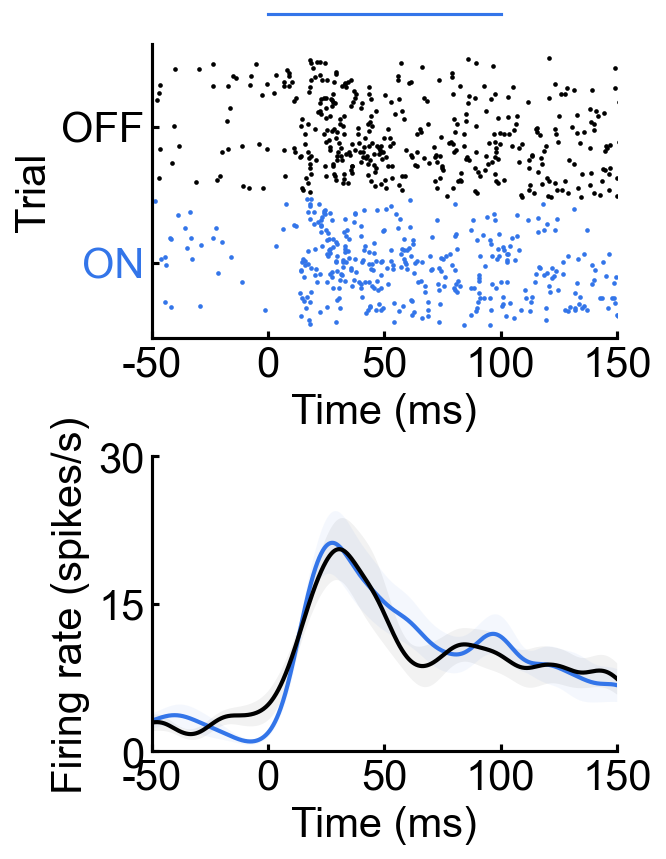

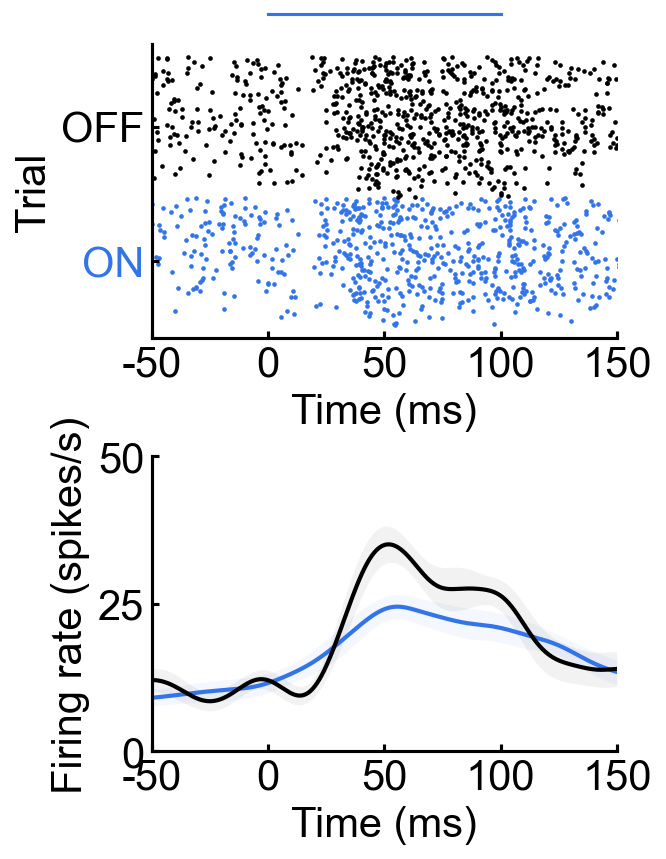

In [47]:
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    limitToUse = None#30
    
    skip = True
#     if session == 'BS_123_7_opto_AC.pickle' and clust in [105]:
#         skip = False
#     if session == 'BS_123_6_opto_AC.pickle' and clust in [51]:
#         skip = False
#     if session == 'BS_123_6_opto_AC.pickle' and clust in [37]:
#         skip = False
#     if session == 'BS_123_7_opto_AC.pickle' and clust in [146]:
#         skip = False
#     if session == 'BS_111_10_opto_AC.pickle' and clust in [54]:
#         skip = False
#     if session == 'BS_119_2_opto_AC.pickle' and clust in [53]:
#         skip = False
    if session == 'BS_119_6_opto_AC.pickle' and clust in [13,45]:
        skip = False
#     if session == 'BS_92_5_opto_AC.pickle' and clust in [247]:
#         skip = False
#     if session == 'BS_111_9_opto_AC.pickle' and clust in [69]:
#         skip = False
#     if session == 'BS_123_6_opto_AC.pickle' and clust in [51]:
#         skip = False
#     if session == 'BS_123_7_opto_AC.pickle' and clust in [146]:
#         skip = False
#     if session == 'BS_128_2_opto_AC.pickle' and clust in [123]:
#         skip = False
#     if session == 'BS_128_1_opto_AC.pickle' and clust in [50]:
#         limitToUse = 100
#         skip = False
    if skip:
        continue
        
    
#     plt.close('all')
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    print(sessionfile.meta.day_of_training)
    if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
        print("Skipping Switch")
        continue
        
    FRmod_on = sessionfile.responsiveness[clust]['laser_on'].FRmodulation
    FRmod_off = sessionfile.responsiveness[clust]['laser_off'].FRmodulation
    modulation_pc = (FRmod_on - FRmod_off) / FRmod_off * 100
    modulation = (FRmod_on - FRmod_off)
#     if modulation_pc < 200:# and modulation < 10:
#         continue
#     if modulation_pc > 25:# and modulation < 10:
#         continue
    
#     fig = plt.figure(figsize=(3,6))
    fig = plt.figure(figsize=(4,6.25))
    gs = fig.add_gridspec(2,1,height_ratios=[1,1],hspace=0.4)#,wspace=0.5)#0.1)
    ax3 = plt.subplot(gs[0,0])#Raster
    ax4 = plt.subplot(gs[1,0],sharex=ax3)#PSTH
    
    #visualizeClusterChoiceInternal(sessionfile,clust,ax1,ax2,Figure_start_time_ms='-250',Figure_end_time_ms=1000,xtickstouse=[-250,0,250,500,750,1000],align_to_choice=False,switch_cond='NA'):
#     success,artists = visualizeClusterChoiceInternal(sessionfile,clust,ax3,ax4,limitToUse=limitToUse,Figure_start_time_ms=-100,Figure_end_time_ms=400,xtickstouse=[0,200,400])
    success,artists = visualizeClusterChoiceInternal(sessionfile,clust,ax3,ax4,limitToUse=limitToUse,Figure_start_time_ms=-50,Figure_end_time_ms=150,xtickstouse=[-50,0,50,100,150])
    if not success:
        continue
    
    #Determine FRmod category
    FRmodCategory = 'ERROR'
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
        if FRmod < 3.5:
            FRmodCategory = 'NCR'
        elif FRmod >= 3.5:
            FRmodCategory = 'CR'
        else:
            FRmodCategory = 'Middle'
    except Exception as e:
        print(e)
        pass
    #Skip unidentified category neurons
    if FRmodCategory in ['ERROR','nan',np.nan]:
        print("FRmodFail Skipping")
        continue
    region = sessionfile.meta.region
    EIL = EILphases[idx]
    #Skip unidentified phase neurons
    if EIL in ['ERROR','nan',np.nan]:
        print("PhaseFail Skipping")
        continue
        
    try:
        if not FRmodCategory == 'ERROR':
            fig.savefig(os.path.join('D:\\\\Rasters','OpsinStimRasters',FRmodCategory,EIL,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','OpsinStimRasters',FRmodCategory,EIL,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','OpsinStimRasters',FRmodCategory,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','OpsinStimRasters',FRmodCategory,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\Rasters','OpsinStimRasters','pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\Rasters','OpsinStimRasters','pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
    except Exception as e:
        print(e)
#     fig.savefig(os.path.join('D:\\\\Rasters','OpsinStimRasters',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')